In [1]:
# imports
import matplotlib.pyplot as plt
from scipy.stats import t
from tqdm import tqdm
import numpy as np
import time
import random

plt.style.use("ggplot")

# Set global font sizes
plt.rcParams.update({
    'font.size': 14,            # base font size
    'axes.titlesize': 16,       # title
    'axes.labelsize': 14,       # x and y labels
    'xtick.labelsize': 14,      # x tick labels
    'ytick.labelsize': 14,      # y tick labels
    'legend.fontsize': 14,      # legend
})

## Make Sample Dataset

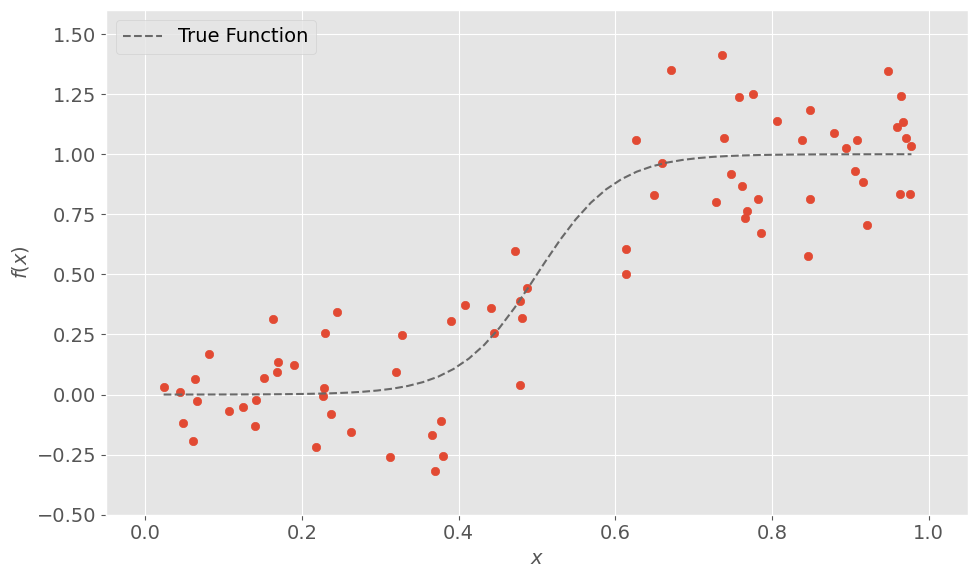

In [20]:
def gen_data(N):
    x = np.random.rand(N)
    y = 1 / (1 + np.exp(-20 * (x - 0.5))) + np.random.normal(loc=0, scale=0.2, size=N)
    return x, y

def gen_data2(N):
    x = np.random.rand(N)
    y = np.sin(x * 2 * np.pi * 6) + np.random.normal(loc=0, scale=0.5, size=N)
    return x, y

# make the figure
plt.figure(figsize=(10, 6))

# make the random data
random.seed(314)
x, y = gen_data(75)

x_axis = np.linspace(min(x), max(x))
y_axis = 1 / (1 + np.exp(-20 * (x_axis - 0.5))) 
plt.scatter(x, y)
plt.plot(x_axis, y_axis, linestyle="--", c="dimgray", label="True Function")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.5, 1.6])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("ExampleDataset")
plt.show()

## Make Default PSpline Class

In [4]:
class PSpline():
    __slots__ = ("x", "y", "n", "alpha", "K", "D", "beta", "sigma2")
    
    def __init__(self, x, y, alpha=1, K=20):
        self.x = x
        self.y = y
        self.n = len(x)
        self.alpha = alpha
        self.K = K
        
        # fit model by computing model parameters
        self.fit(x, y)
        
    def createDesign(self, x):
        # create the design matrix X for x|K
        X = np.ones(shape=(len(x), self.K+4))
        X[:, 1] = x
        X[:, 2] = x ** 2
        X[:, 3] = x ** 3
        
        # loop over equally spaced knots along x
        knots = np.linspace(min(self.x), max(self.x), self.K)
        for i, k in enumerate(knots):
            X[:, i+4] = np.clip((x-k)**3, a_min=0, a_max=None)
        return X
        
    def fit(self, x, y):
        # make diagonal for stability
        self.D = np.eye(self.K + 4)
        
        # make the design matrix
        X = self.createDesign(x)
        
        # fit model by estimating parameters
        self.beta = np.linalg.inv(X.T @ X + self.alpha * self.D) @ X.T @ self.y
        self.sigma2 = np.mean((self.y - self.f(self.x)) ** 2)
    
    def ASR(self):
        return np.mean((self.y - self.f(self.x)) ** 2)
    
    def traceS(self):
        X = self.createDesign(self.x)
        return np.trace(X @ np.linalg.inv((X.T @ X + self.alpha * self.D)) @ X.T)
    
    def GCV(self, lamb=1):
        return self.ASR() / (1 - lamb / self.n * self.traceS()) ** 2
    
    def f(self, x_star):
        # compute predictions
        y_hat = self.createDesign(x_star) @ self.beta
        return y_hat


In [5]:
# loop through alphas keeping track of the best
alphas = np.logspace(-10, 12, 100)
best = float("inf")
for alpha in alphas:
    model = PSpline(x, y, alpha=alpha, K=20)
    gcv = model.GCV()

    if gcv <= best:
        alpha_star = alpha
        best = gcv
    else:
        pass
    
print(alpha_star)

1.2915496650148827e-05


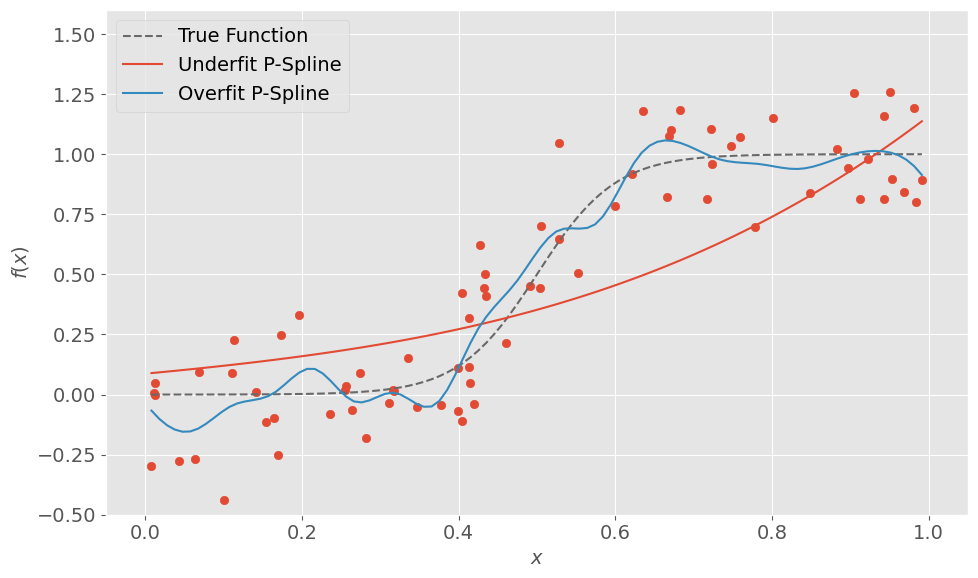

In [6]:
under_model = PSpline(x, y, alpha=10, K=20)
over_model = PSpline(x, y, alpha=1e-9, K=20)

x_axis = np.linspace(min(x), max(x), 100)

plt.figure(figsize=(10, 6))

y_true = 1 / (1 + np.exp(-20 * (x_axis - 0.5))) 
plt.scatter(x, y)
plt.plot(x_axis, y_true, linestyle="--", c="dimgray", label="True Function")
plt.plot(x_axis, under_model.f(x_axis), label="Underfit P-Spline")
plt.plot(x_axis, over_model.f(x_axis), label="Overfit P-Spline")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.5, 1.6])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.legend()
plt.tight_layout()
plt.savefig("MotivationExample", dpi=300)
plt.show()

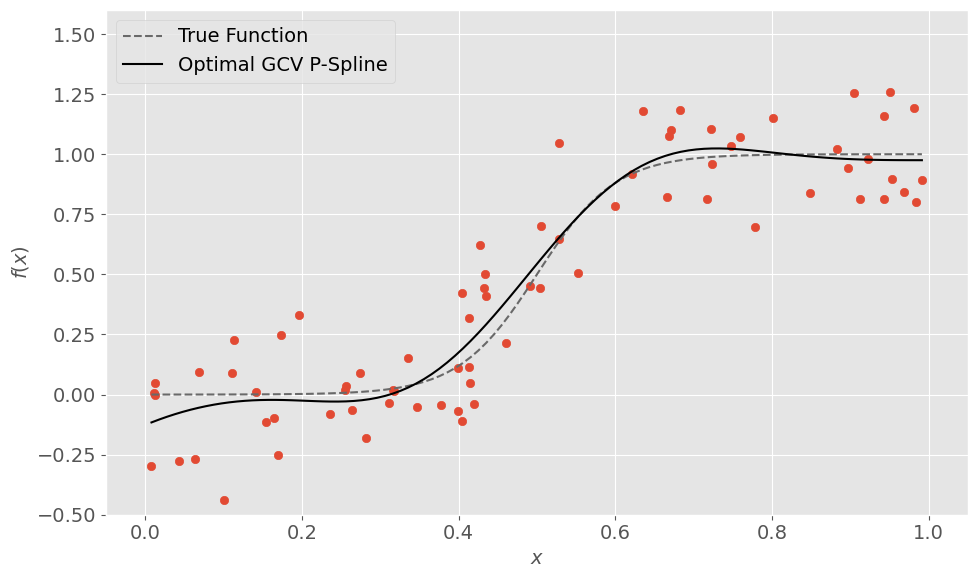

In [9]:
right_model = PSpline(x, y, alpha=alpha_star, K=20)

x_axis = np.linspace(min(x), max(x), 100)

plt.figure(figsize=(10, 6))

y_true = 1 / (1 + np.exp(-20 * (x_axis - 0.5))) 
plt.scatter(x, y)
plt.plot(x_axis, y_true, linestyle="--", c="dimgray", label="True Function")
plt.plot(x_axis, right_model.f(x_axis), label="Optimal GCV P-Spline", c="k")
plt.xlim([-0.05, 1.05])
plt.ylim([-0.5, 1.6])
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("BestExample", dpi=300)
plt.show()

## Make Optimized PSpline Class

In [12]:
class PSplineOpt():
    __slots__ = ("x", "y", "n", "alpha", "K", "X", "D", "C", "Z", "beta", "sigma2")
    
    def __init__(self, x, y, alpha=1, K=20):
        self.x = x
        self.y = y
        self.n = len(x)
        self.alpha = alpha
        self.K = K
        self.D = np.eye(K + 4)
        
        # create the optimized matricies
        self.X = self.createDesign(x)
        B = np.linalg.inv(np.linalg.cholesky(self.X.T @ self.X + 1e-10 * np.eye(K+4)))
        C, U = np.linalg.eigh(B @ self.D @ B.T)
        
        # save the eigenvalues matrix
        self.C = C
        self.Z = self.X @ (B.T @ U)
        
        # fit the model
        self.fit(x, y)
        
    def createDesign(self, x):
        # create the design matrix X for x|K
        X = np.ones(shape=(len(x), self.K+4))
        X[:, 1] = x
        X[:, 2] = x ** 2
        X[:, 3] = x ** 3
        
        # loop over equally spaced knots along x
        knots = np.linspace(min(self.x), max(self.x), self.K)
        for i, k in enumerate(knots):
            X[:, i+4] = np.clip((x-k)**3, a_min=0, a_max=None)
        return X
    
    def fit(self, x, y):
        # loop through alphas keeping track of the best
        alphas = np.logspace(-10, 12, 100)
        best = float("inf")
        for alpha in alphas:
            gcv = self.GCV(alpha=alpha)
            
            if gcv <= best:
                self.alpha = alpha
                best = gcv
            else:
                pass
        
        # fit model parameters with optimal alpha
        self.beta = np.linalg.inv(self.X.T @ self.X + self.alpha * self.D) @ self.X.T @ self.y
        self.sigma2 = np.mean((self.y - self.f(self.x)) ** 2)
        
    def traceS(self, alpha):
        return np.sum(1 / (1 + alpha * self.C))
    
    def ASR(self, alpha):
        lambda_vec = np.linalg.inv((np.eye(self.K + 4) + alpha * np.diag(self.C))) @ self.Z.T @ self.y
        return np.mean( (self.y - self.Z @ lambda_vec)**2 )
    
    def GCV(self, alpha, lamb=1):
        return self.ASR(alpha) / (1 - lamb / self.n * self.traceS(alpha)) ** 2
    
    def f(self, x_star):
        # compute predictions
        y_hat = self.createDesign(x_star) @ self.beta
        return y_hat
    
    def interval(self, x_star, interval_type=0, alpha=0.95):
        # compute variance-covariance matrix
        X_star = self.createDesign(x_star)
        XtX_inv = np.linalg.inv(self.X.T @ self.X + 1e-10 * np.eye(self.K + 4))

        # vectorize computation of predictive variance
        pred_var = interval_type + np.einsum('ij,jk,ik->i', X_star, XtX_inv, X_star)
        pred_std = np.sqrt(self.sigma2 * pred_var)  # 1 = prediction interval, 0 = confidence interval
            
        # compute other components
        mu = self.f(x_star)
        t_val = t.ppf((1-alpha) / 2, df=self.n - (self.K + 4))

        # return prediction interval
        return mu - t_val * pred_std, mu + t_val * pred_std

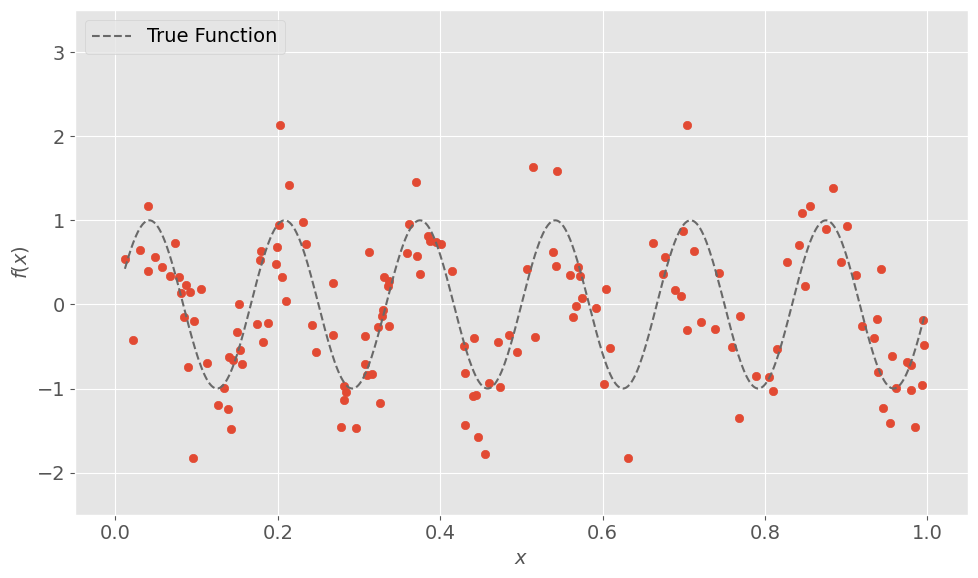

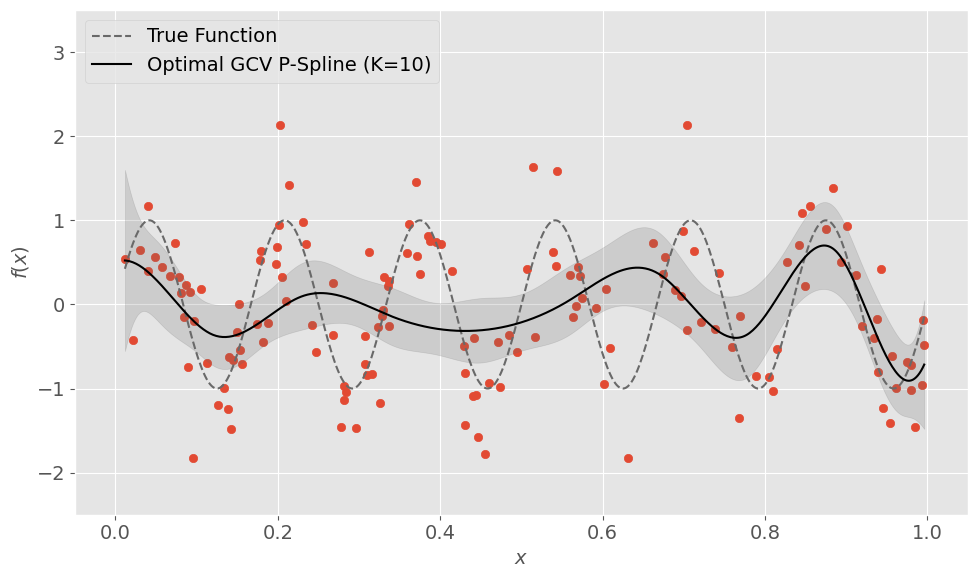

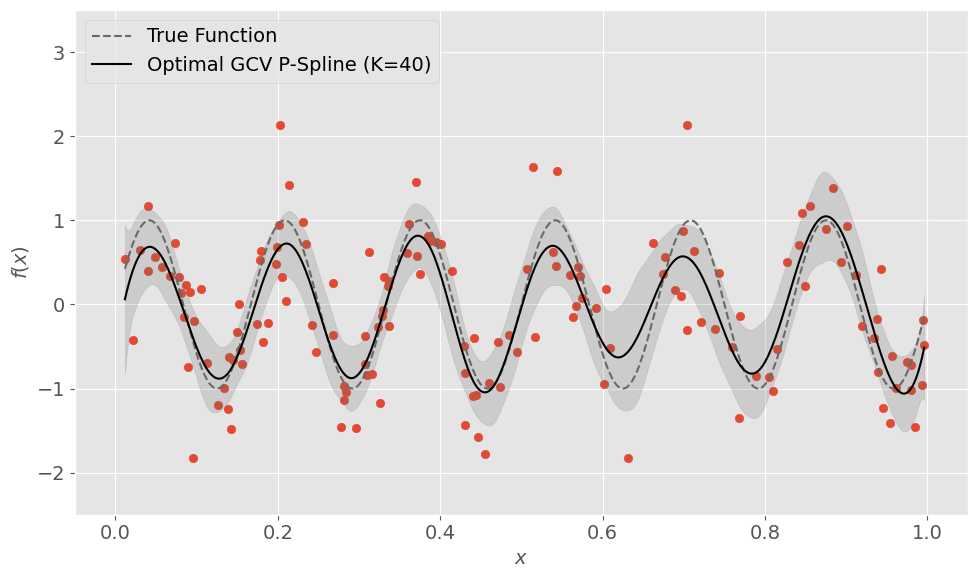

In [48]:
# make more complex example of the sin
x, y = gen_data2(N=150)

# fit the best model efficiently
model = PSplineOpt(x, y, alpha=1, K=10)
# predict on a grid of x's
x_axis = np.linspace(min(x), max(x), 500)
y_hat = model.f(x_axis)
y_true = np.sin(x_axis * 2 * np.pi * 6)
upper, lower = model.interval(x_axis, interval_type=0)

# display data
plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.plot(x_axis, y_true, linestyle="--", c="dimgray", label="True Function")
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim([-0.05, 1.05])
plt.ylim([-2.5, 3.5])
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("BadExampleData.png", dpi=300)
plt.show()

# display results
plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.plot(x_axis, y_true, linestyle="--", c="dimgray", label="True Function")
plt.plot(x_axis, y_hat, label="Optimal GCV P-Spline (K=10)", c="k")
plt.fill_between(x_axis, lower, upper, color='dimgray', alpha=0.2)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim([-0.05, 1.05])
plt.ylim([-2.5, 3.5])
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("BadExampleFit.png", dpi=300)
plt.show()

# fit the best model efficiently
model = PSplineOpt(x, y, alpha=1, K=40)

# predict on a grid of x's
y_hat = model.f(x_axis)
y_true = np.sin(x_axis * 2 * np.pi * 6)
upper, lower = model.interval(x_axis, interval_type=0)

# display results
plt.figure(figsize=(10, 6))
plt.scatter(x, y)
plt.plot(x_axis, y_true, linestyle="--", c="dimgray", label="True Function")
plt.plot(x_axis, y_hat, label="Optimal GCV P-Spline (K=40)", c="k")
plt.fill_between(x_axis, lower, upper, color='dimgray', alpha=0.2)
plt.xlabel(r"$x$")
plt.ylabel(r"$f(x)$")
plt.xlim([-0.05, 1.05])
plt.ylim([-2.5, 3.5])
plt.legend(loc="upper left")
plt.tight_layout()
plt.savefig("BadExampleBestFit.png", dpi=300)
plt.show()

# Do Bakeoff To Test Speed

In [8]:
def fit_regular(x, y):
    # loop through alphas keeping track of the best
    alphas = np.logspace(-10, 12, 100)
    best = float("inf")
    for alpha in alphas:
        model = PSpline(x, y, alpha=alpha, K=20)
        gcv = model.GCV()

        if gcv <= best:
            alpha_star = alpha
            best = gcv
        else:
            pass

    model = PSpline(x, y, alpha=alpha_star, K=20)
    return True

def fit_optimal(x, y):
    # fit the best model efficiently
    model = PSplineOpt(x, y, alpha=1, K=20)
    return True

# Compare Runtimes

In [22]:
def run_bakeoff(n_points=1000, num_trials=100):
    """Runs the bakeoff timing comparison and generates a boxplot."""
    
    # arrays to store runtimes
    reg_times = np.zeros(num_trials)
    opt_times = np.zeros(num_trials)
    
    for i in tqdm(range(num_trials), desc="Running Bakeoff"):
        
        # generate data
        x, y = gen_data(n_points)

        # run first algorithm
        start_time = time.time()
        fit_regular(x, y)
        reg_times[i] = time.time() - start_time
        
        # run second algorithm
        start_time = time.time()
        fit_optimal(x, y)
        opt_times[i] = time.time() - start_time

    # plot the results
    plt.figure(figsize=(10, 6))
    plt.boxplot([reg_times, opt_times], labels=['Naive GCV Optimization', 'Diagonalized GCV Optimization'], vert=True)
    plt.ylabel("Runtime (seconds)")
    plt.ylim(bottom=0)
    plt.grid(True)
    plt.savefig("RuntimeNExample", dpi=300)
    plt.tight_layout()
    plt.show()

Running Bakeoff: 100%|████████████████████████| 100/100 [00:55<00:00,  1.81it/s]


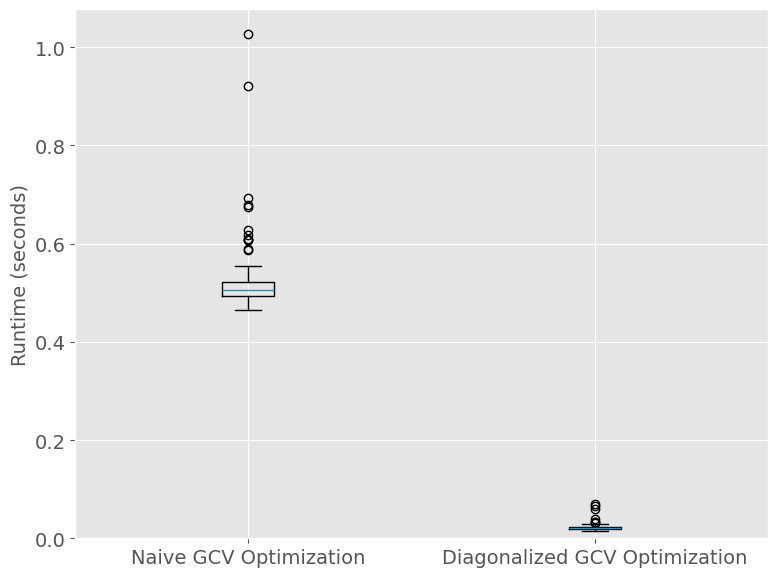

In [23]:
random.seed(314)
run_bakeoff(n_points=1_000, num_trials=100)

# Compare Scaling With N

In [11]:
def run_comparison(nmin=30, nmax=1000, nsteps=10, nreps=30):
    """Runs a bakeoff comparison over an increasing size n"""
    
    ns = np.linspace(nmin, nmax, nsteps, dtype=int)
    
    # arrays to store runtimes
    reg_times = np.zeros_like(ns, dtype=float)
    opt_times = np.zeros_like(ns, dtype=float)
    
    for i, n in enumerate(tqdm(ns, desc="Running Comparison")):
        
        for j in range(nreps):
        
            # generate data
            x, y = gen_data(n_points)

            # run first algorithm
            start_time = time.time()
            fit_regular(x, y)
            reg_times[i] += (time.time() - start_time) / nreps

            # run second algorithm
            start_time = time.time()
            fit_optimal(x, y)
            opt_times[i] += (time.time() - start_time) / nreps

    # plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(ns, opt_times, label='Diagonalized GCV Optimization')
    plt.plot(ns, reg_times, label='Naive GCV Optimization')
    plt.ylabel("Runtime (seconds)")
    plt.xlabel("Data Size (n)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("ScalingNExample", dpi=300)
    plt.show()

Running Comparison: 100%|███████████████████████| 10/10 [01:49<00:00, 10.94s/it]


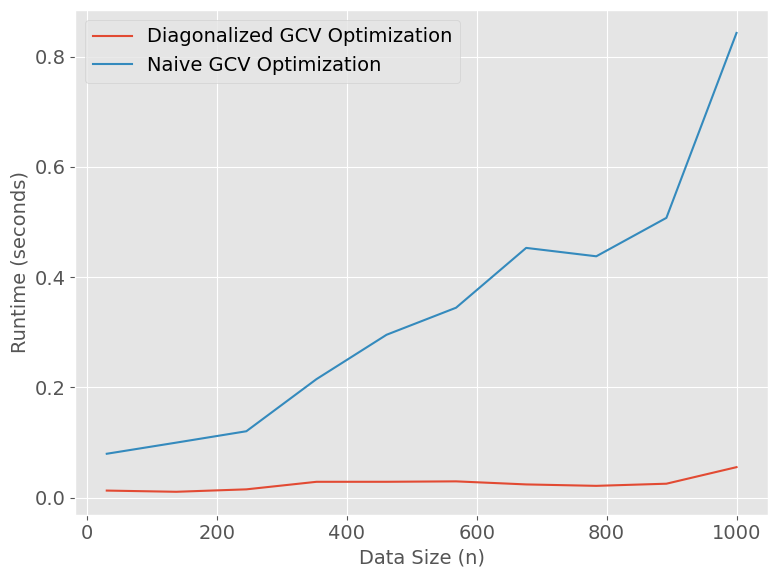

In [12]:
random.seed(314)
run_comparison(nmin=30, nmax=1_000, nsteps=10, nreps=30)

# Limit Test

In [13]:
def limit_test(nmin=30, nmax=10_000, nsteps=50, nreps=10):
    """Runs a bakeoff comparison over an increasing size n"""
    
    # make an integer equally spaced array of n's
    ns = np.linspace(nmin, nmax, nsteps, dtype=int)
    
    # arrays to store runtimes
    opt_times = np.zeros_like(ns, dtype=float)
    
    for i, n in enumerate(tqdm(ns, desc="Running Limit Test")):
        
        for j in range(nreps):
        
            # generate data
            x, y = gen_data(n_points)

            # run second algorithm
            start_time = time.time()
            fit_optimal(x, y)
            opt_times[i] += (time.time() - start_time) / nreps

    # plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(ns, opt_times, label='Diagonalized GCV Optimization')
    plt.ylabel("Runtime (seconds)")
    plt.xlabel("Data Size (n)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("LimitTestNExample", dpi=300)
    plt.show()

Running Limit Test: 100%|███████████████████████| 10/10 [01:28<00:00,  8.89s/it]


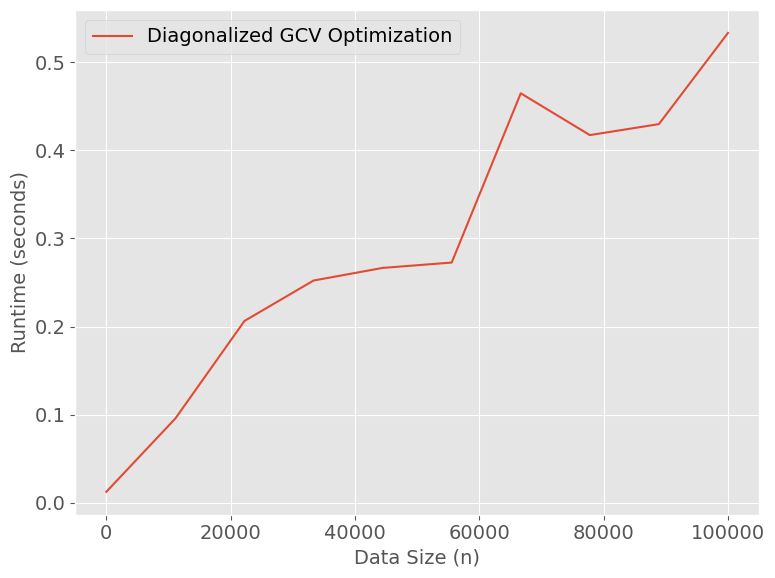

In [14]:
random.seed(314)
limit_test(nmin=30, nmax=100_000, nsteps=10, nreps=30)

# Example Usages